In [1]:
#load libraries
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata
import h5py

import celloracle as co

In [2]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
# input and output paths
output_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/celloracle_outs"
KO_adata_path = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_all/objects/KO_major_celltype.h5ad"
WT_adata_path = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_all/objects/WT_major_celltype.h5ad"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Load anndata objects
KO_anndata = sc.read_h5ad(KO_adata_path)
WT_anndata = sc.read_h5ad(WT_adata_path)

KO_anndata
#RNA_snn_res.0.8 is the cell-type label of final clusters

AnnData object with n_obs × n_vars = 22187 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'

In [57]:
# SUBSET the anndata to only have the highly_variable features for the downstream analysis
sc.pp.highly_variable_genes(KO_anndata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
sc.pp.highly_variable_genes(WT_anndata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
subset_KO = KO_anndata[:, KO_anndata.var['highly_variable']]
subset_WT = WT_anndata[:, WT_anndata.var['highly_variable']]
subset_WT

View of AnnData object with n_obs × n_vars = 17919 × 2983
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'harmony', 'pca', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'

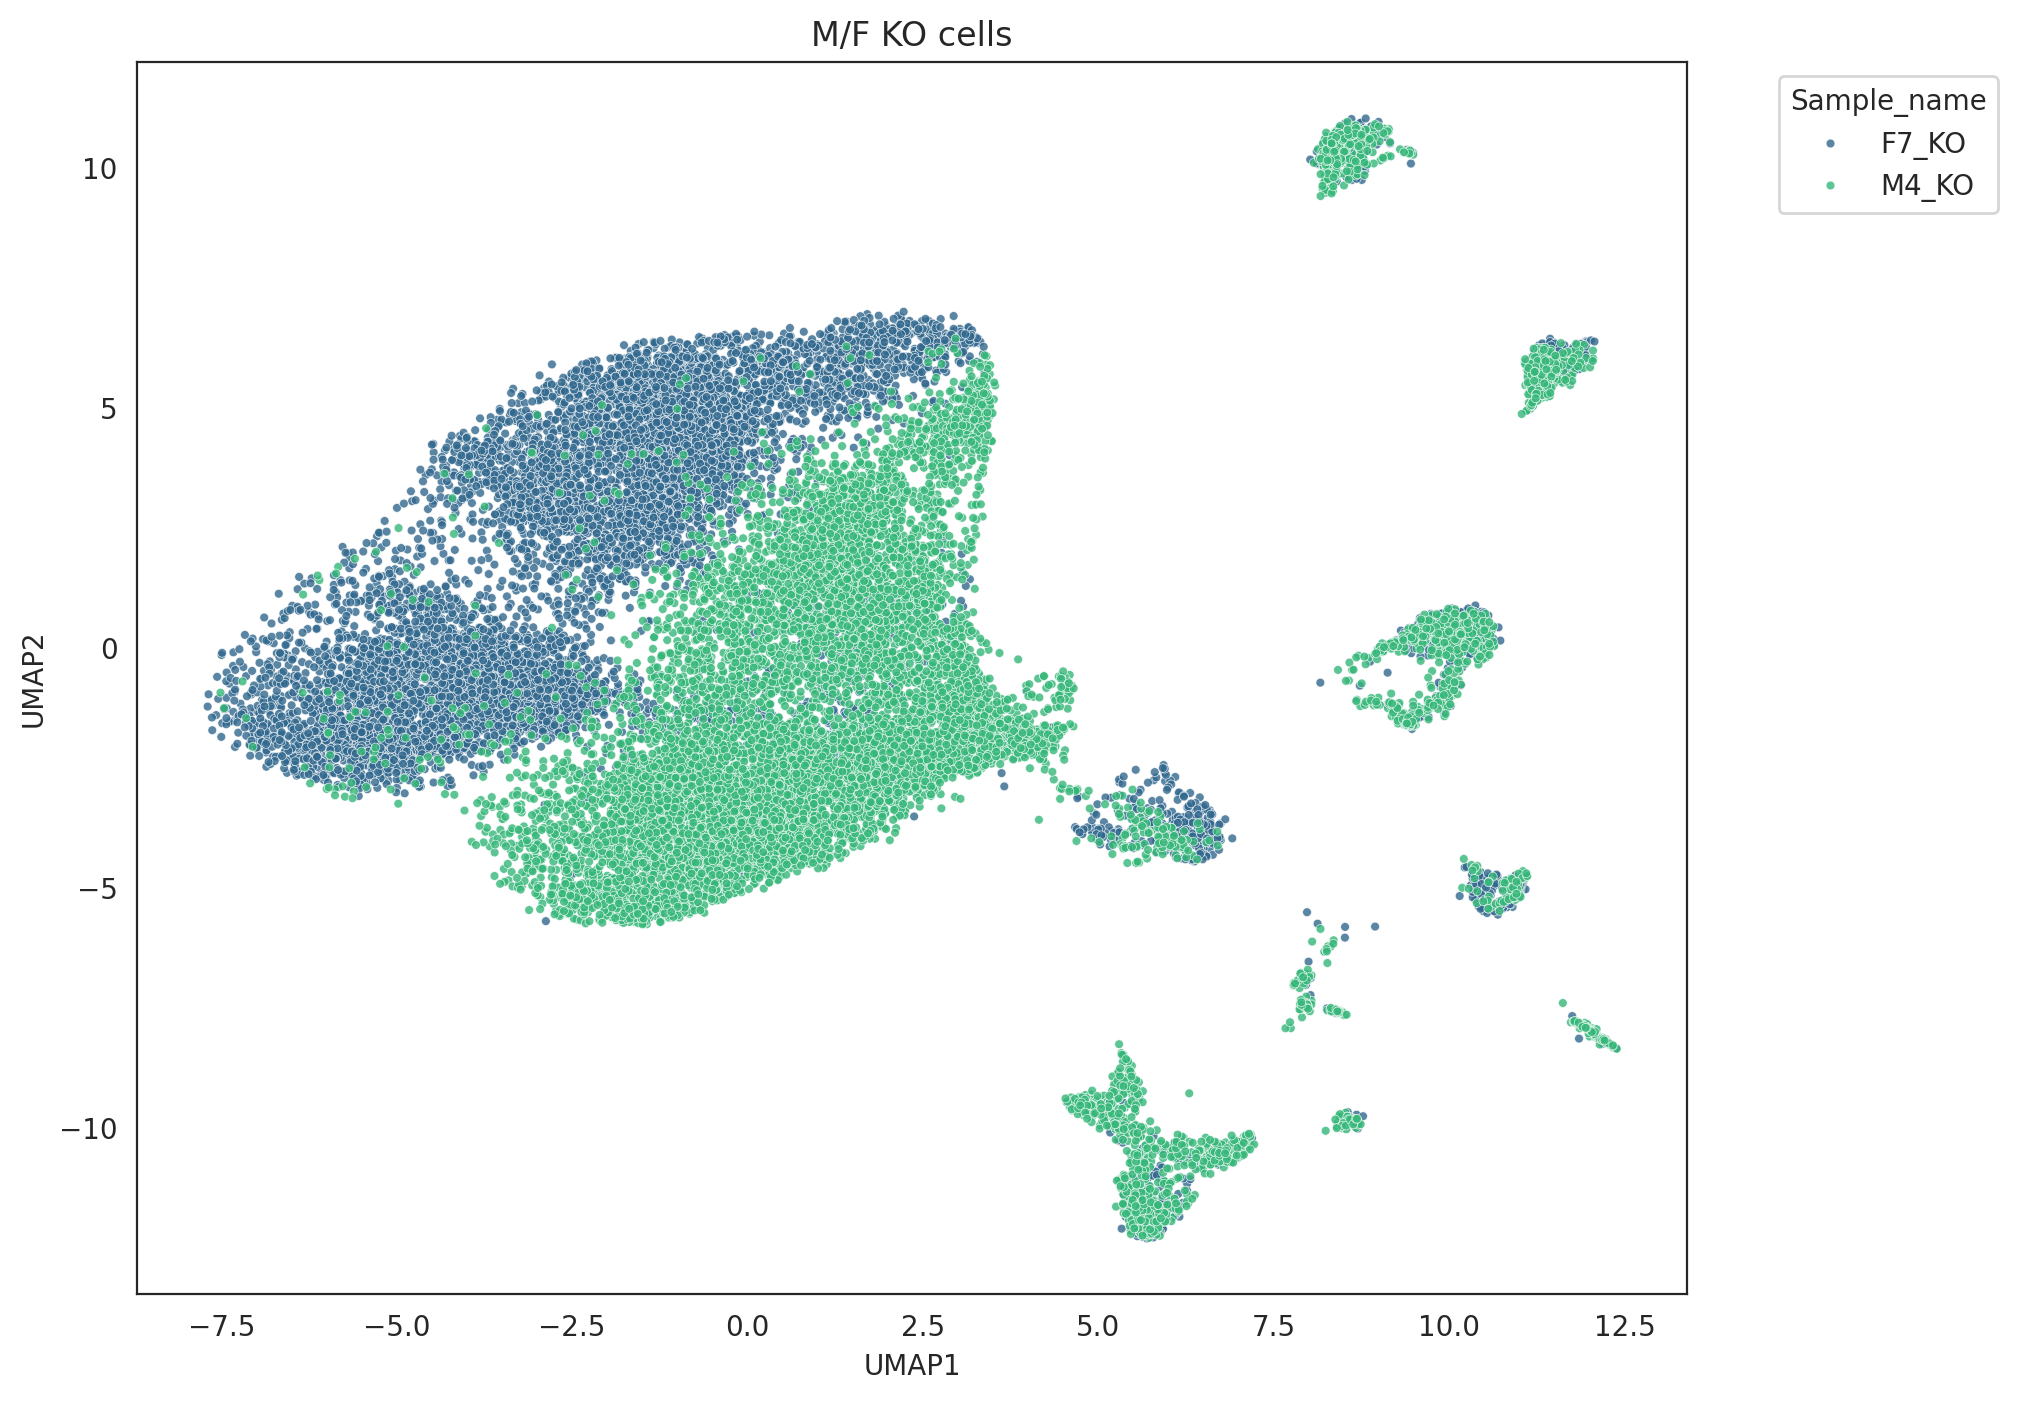

In [59]:
# viz the UMAP with cluster colors
umap_coords = KO_anndata.obsm['X_umap']
cluster_labels = KO_anndata.obs['orig.ident']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=cluster_labels, palette='viridis', s=10, alpha=0.8)
plt.title('M/F KO cells')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Sample_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


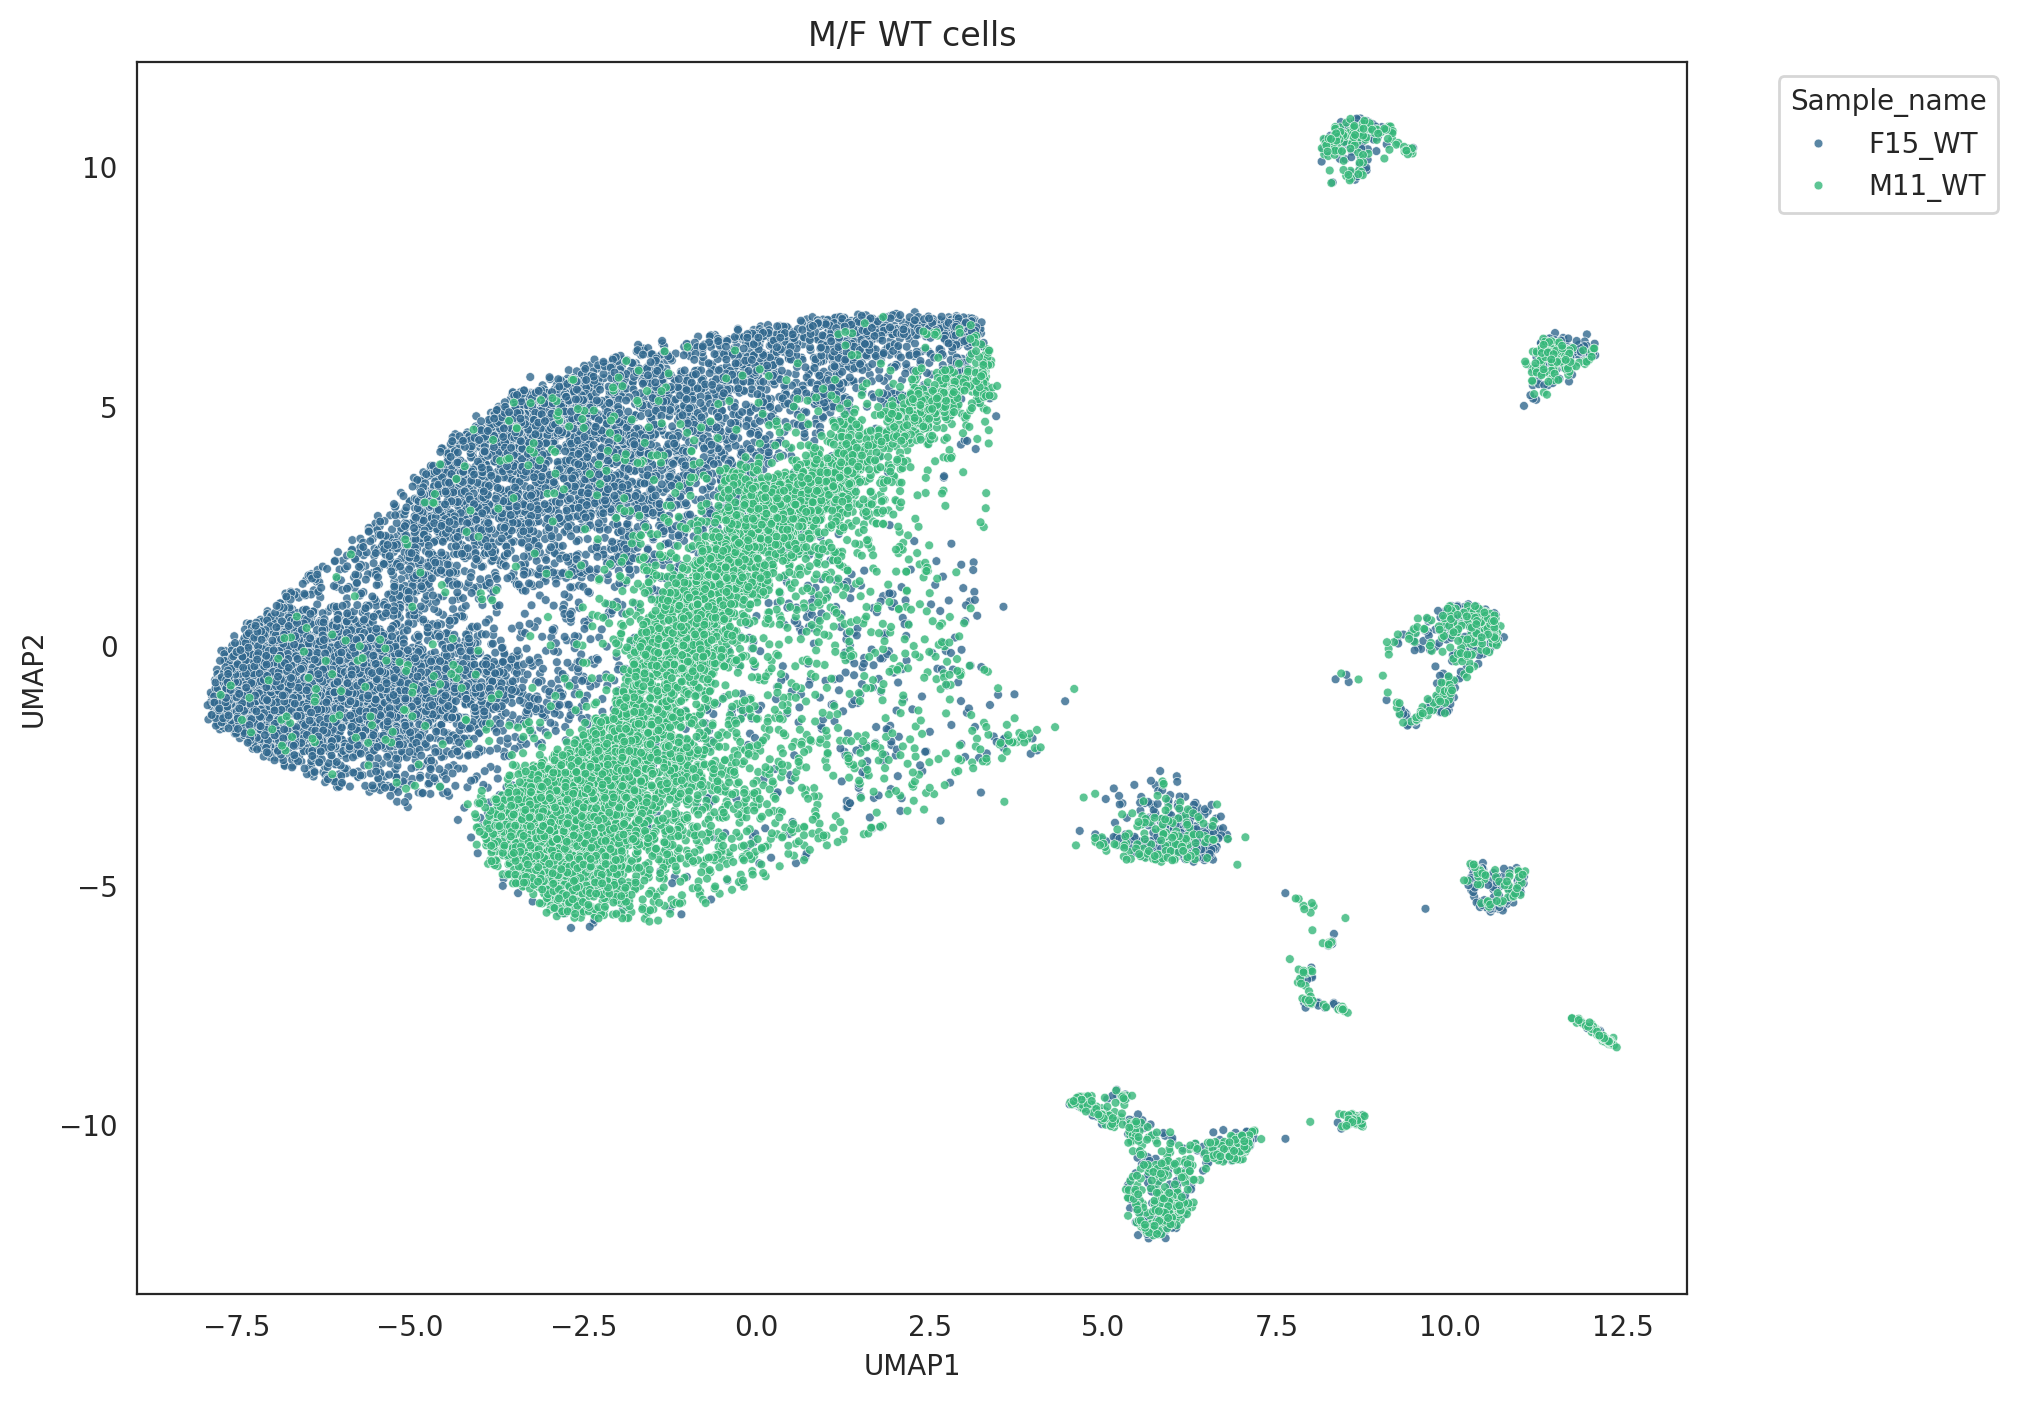

In [62]:
# viz the UMAP with cluster colors
umap_coords = WT_anndata.obsm['X_umap']
cluster_labels = WT_anndata.obs['orig.ident']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=cluster_labels, palette='viridis', s=10, alpha=0.8)
plt.title('M/F WT cells')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Sample_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [63]:
# load a pre-computed base grn 
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## KO Cells GRN inference

... storing 'orig.ident' as categorical
... storing 'condition' as categorical


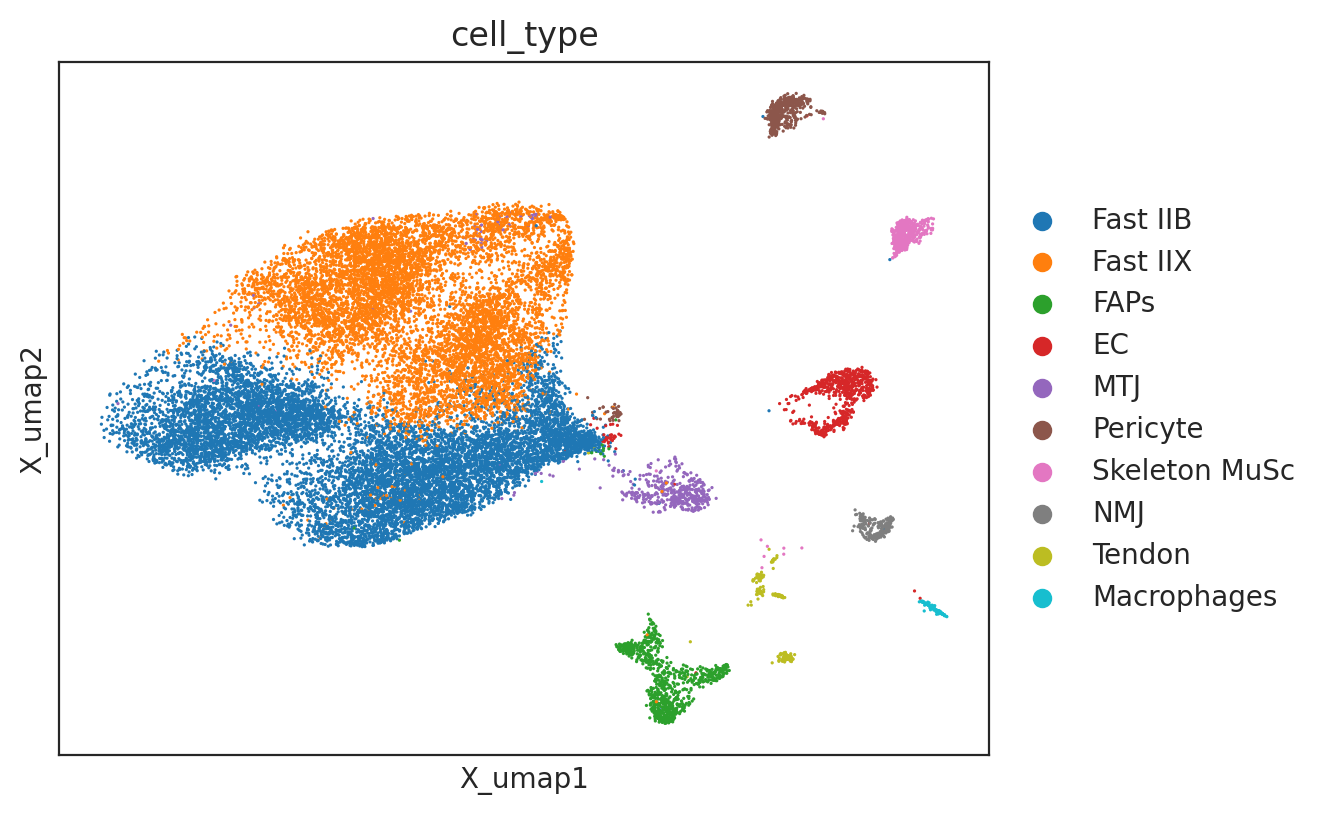

In [64]:
#load oracle object
oracle = co.Oracle() 
# use unscaled counts for grn inference 
subset_KO.X = subset_KO.layers['counts'].copy()
#load data in the oracle object
oracle.import_anndata_as_raw_count(adata=subset_KO, cluster_column_name='cell_type', embedding_name='X_umap')
oracle.import_TF_data(TF_info_matrix=base_GRN)

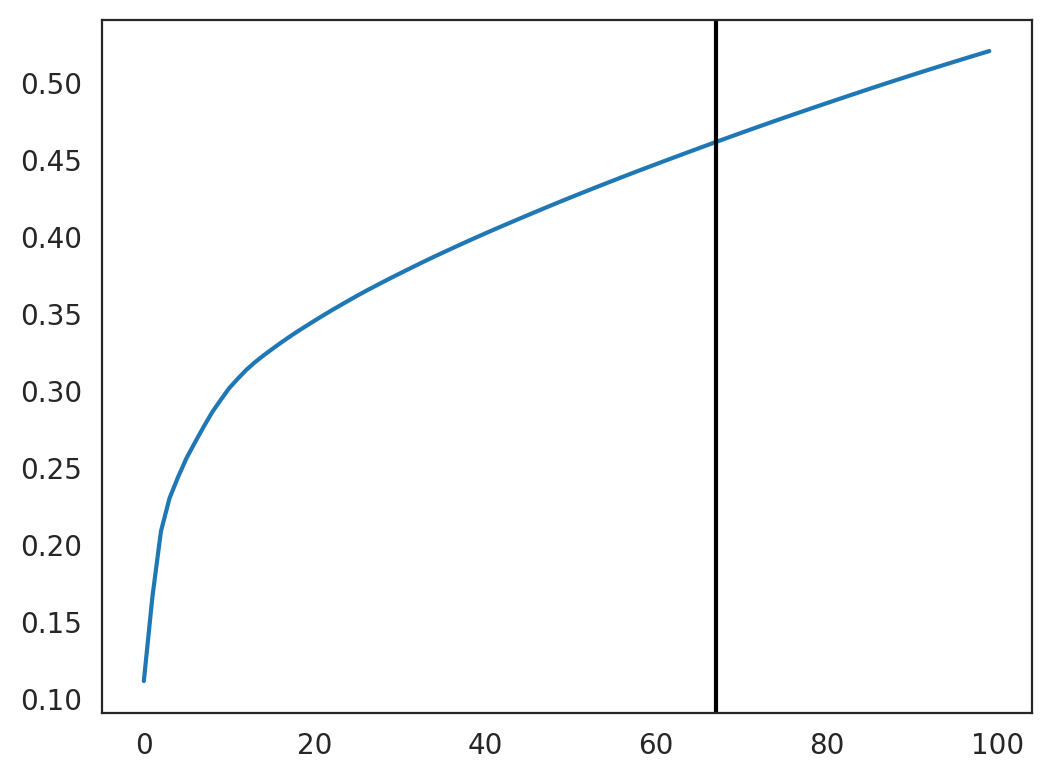

67


In [65]:
#KNN imputation: get lower dim embedding of features by pca
oracle.perform_PCA() #as we used raw counts from anndata to make this oracle object
#select top PCs by thresholding the number of components by the ratio of variance explained by them
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [68]:
#KNN imputation: run nearest neighbor imputation
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")


cell number is :22187


In [69]:
#KNN imputation: run nearest neighbor imputation
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

Auto-selected k is :554


In [ ]:
%%time
#Construct GRN for each cell-type 
links = oracle.get_links(cluster_name_for_GRN_unit = "cell_type", alpha=10, verbose_level=10)

In [ ]:
#save the links
links_dict_df = pd.DataFrame([(k, v) for k, values in links.links_dict.items() for v in values], columns=['Key', 'Value'])
links_dict_df.to_csv("/ix/djishnu/Akanksha/ERCC1_snRNA_analysis/CellOracle_analysis_outputs/links_dict_KO.csv", index=False)